<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Remove randomness
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

2025-11-29 20:03:38.913509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/train", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    seed=123,
)

Found 257 files belonging to 11 classes.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/validation", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    seed=123,
)

Found 86 files belonging to 11 classes.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    seed=123,
)

Found 89 files belonging to 11 classes.


In [5]:
class_names = train_ds.class_names
class_names

['allen key',
 'chisel',
 'file',
 'hammer',
 'mallet',
 'plier',
 'saw',
 'scrapper',
 'screw driver flat',
 'screw driver star',
 'spanner']

2025-11-29 20:03:50.928187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


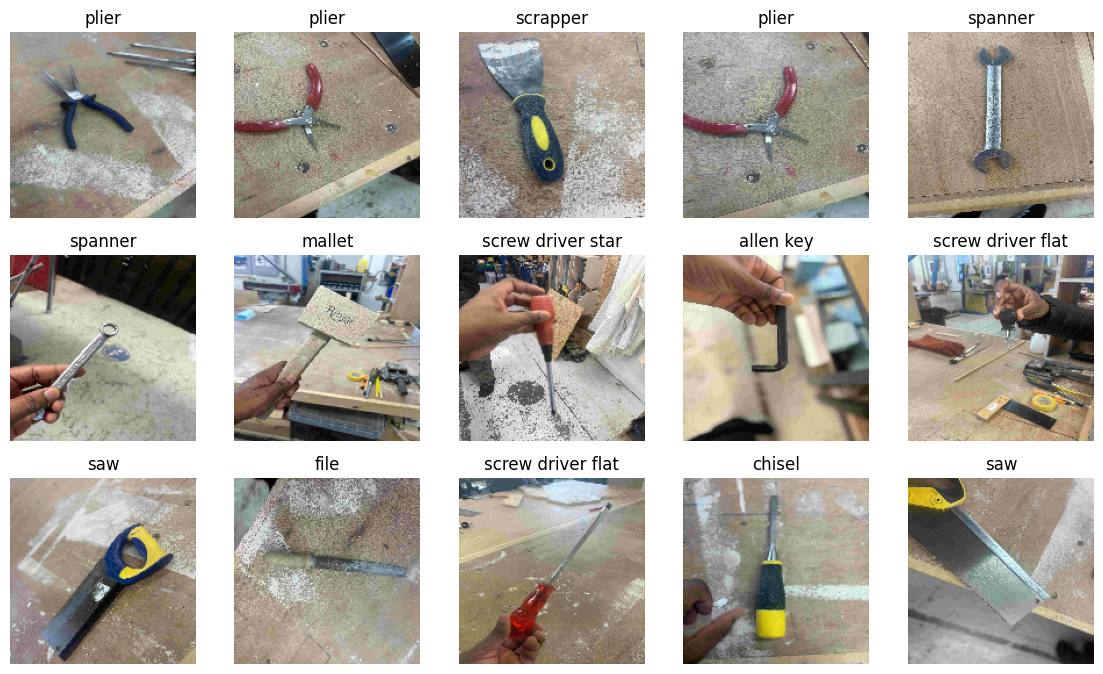

In [6]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 9
Number of validation batches: 3
Number of test batches: 3


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Because I don't have a large image dataset, I'm to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduces overfitting

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
])

2025-11-29 20:03:53.670616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


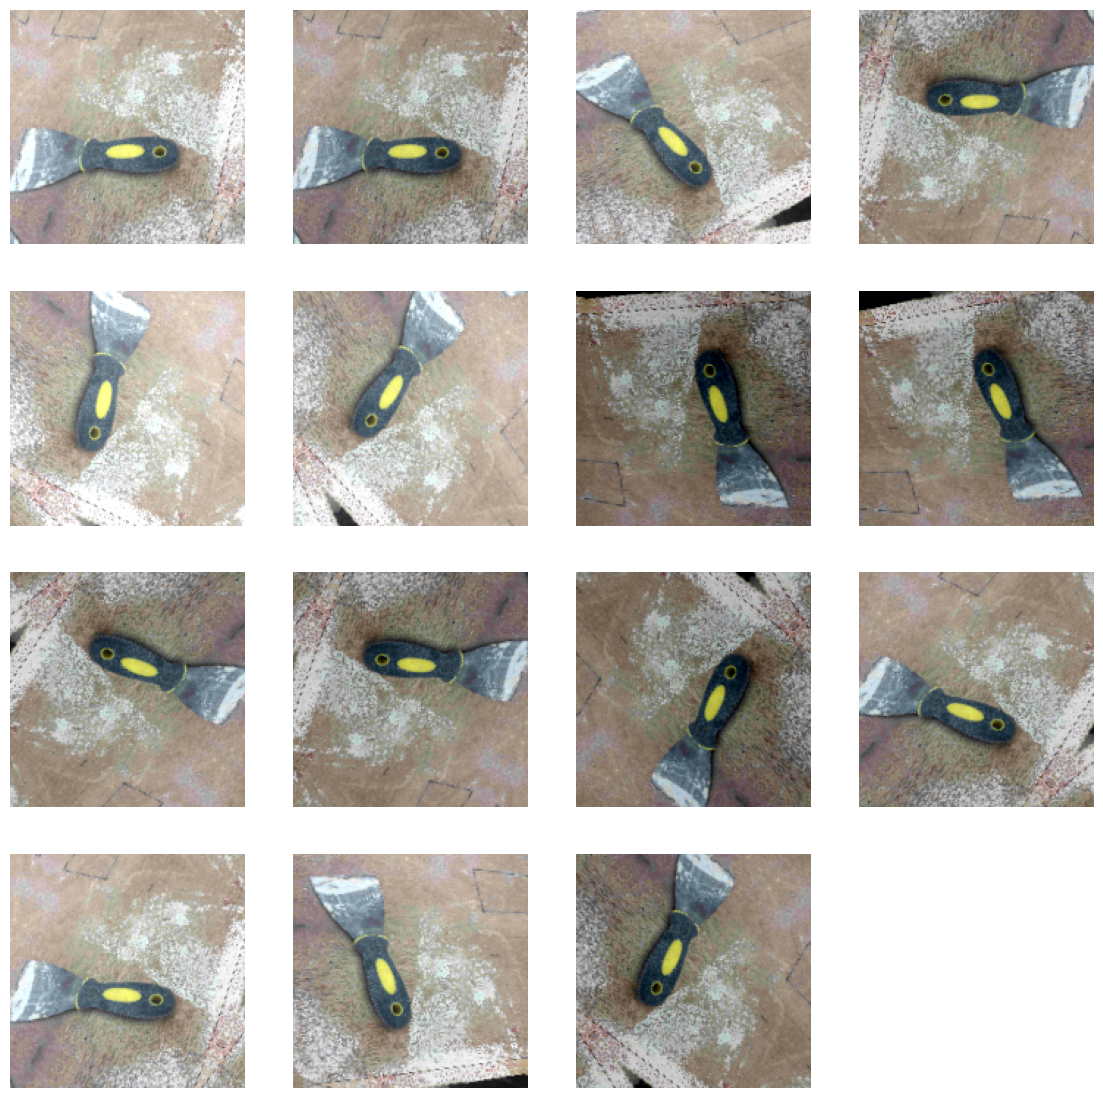

In [10]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the models



In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


def classifer_model(is_mobilenet, base_learning_rate, fine_tune=False):
    rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    # Create the base model from the pre-trained model MobileNet V2
    IMAGE_SHAPE = IMG_SIZE + (3,)

    if is_mobilenet:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    image_batch, label_batch = next(iter(train_ds))
    feature_batch = base_model(image_batch)


    print("Number of layers in the base model: ", len(base_model.layers))

    if fine_tune:
        fine_tune_at = 50
        #for layer in base_model.layers[:fine_tune_at]:
        #  layer.trainable = False
    else:
        base_model.trainable = False # Freeze all the layers of the model
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(11, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)
    
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

        

### Model Test

In [12]:
learning_rate = 0.0001
mobile_netv2 = classifer_model(True, learning_rate)
inception_v3 = classifer_model(False, learning_rate)
mobile_netv2_finetune = classifer_model(True, learning_rate, True)
inception_v3_finetune = classifer_model(False, learning_rate, True)

Number of layers in the base model:  154
Number of layers in the base model:  311
Number of layers in the base model:  154
Number of layers in the base model:  311


In [13]:
initial_epochs = 80

loss0, accuracy0 = mobile_netv2.evaluate(val_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 699ms/step - accuracy: 0.0930 - loss: 3.0179


In [14]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.02
initial accuracy: 0.09


In [15]:
history_mobile_netv2 = mobile_netv2.fit(
    train_ds, 
    epochs=initial_epochs, 
    validation_data=val_ds, 
    callbacks=tensorboard_callback
)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0467 - loss: 3.1744 - val_accuracy: 0.1047 - val_loss: 2.7610
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0661 - loss: 2.8894 - val_accuracy: 0.1628 - val_loss: 2.5844
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.0973 - loss: 2.7901 - val_accuracy: 0.1860 - val_loss: 2.4656
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1362 - loss: 2.6257 - val_accuracy: 0.1977 - val_loss: 2.3801
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1362 - loss: 2.5377 - val_accuracy: 0.2093 - val_loss: 2.3145
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.1946 - loss: 2.3776 - val_accuracy: 0.2326 - val_loss: 2.2616
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.1751 - loss: 2.4129 - val_accuracy: 0.2907 - val_loss: 2.2220
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1984 - loss: 2.4114 - val_accuracy: 0.2791 - val_loss: 2.1825
Epoch 9/

In [16]:
history_inception_v3 = inception_v3.fit(
    train_ds, 
    epochs=initial_epochs, 
    validation_data=val_ds,
    callbacks=tensorboard_callback
)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.0700 - loss: 4.1910 - val_accuracy: 0.0814 - val_loss: 3.3008
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.1012 - loss: 3.8089 - val_accuracy: 0.0814 - val_loss: 3.1134
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.0895 - loss: 3.5832 - val_accuracy: 0.1047 - val_loss: 3.0072
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.1634 - loss: 3.3064 - val_accuracy: 0.1279 - val_loss: 2.9006
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.1440 - loss: 3.2693 - val_accuracy: 0.1279 - val_loss: 2.8018
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2062 - loss: 3.0641 - val_accuracy: 0.1395 - val_loss: 2.6921
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2062 - loss: 2.9346 - val_accuracy: 0.1628 - val_loss: 2.5968
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.1673 - loss: 2.9769 - val_accuracy: 0.1744 - val_loss: 2.5115
Epoch 9/

In [17]:
def plot_train_val_stat(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

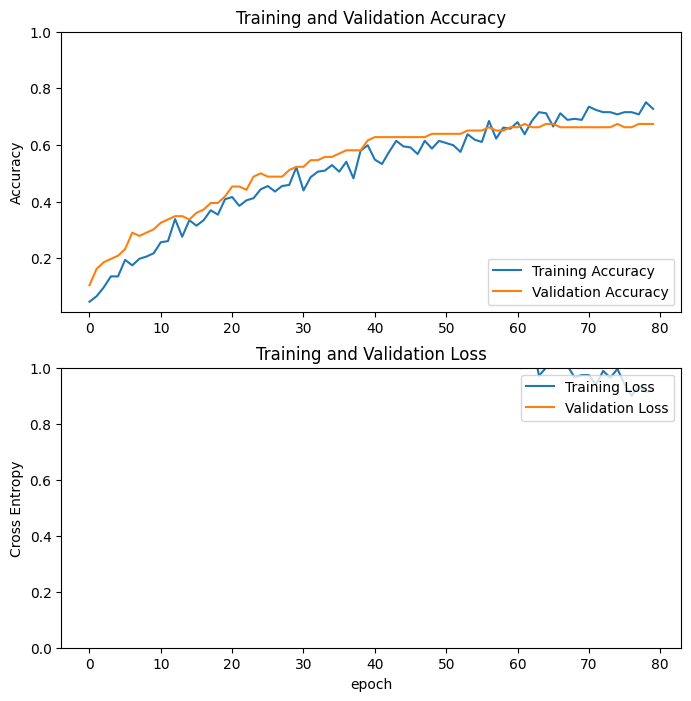

In [18]:
plot_train_val_stat(history_mobile_netv2)

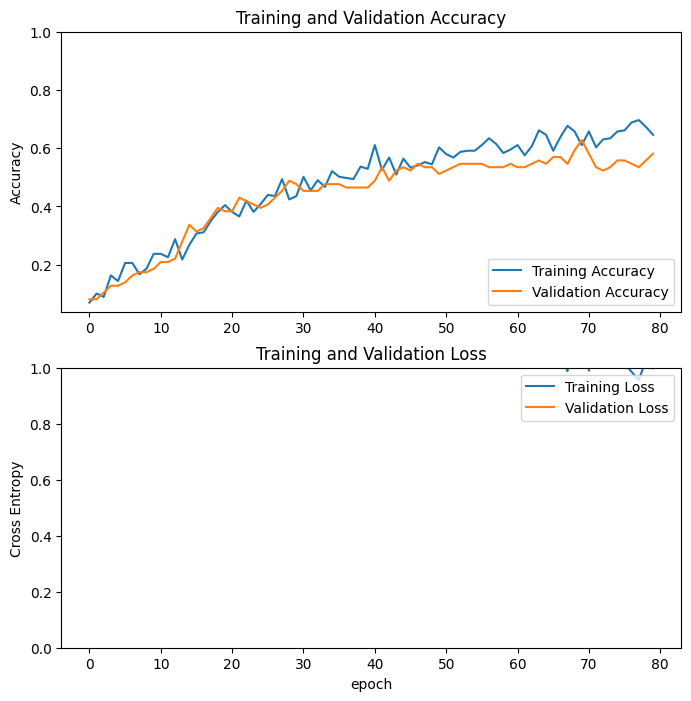

In [19]:
plot_train_val_stat(history_inception_v3)

In [20]:
def get_images_true_labels(dataset):
    images = []
    true_labels = []
    # Iterate through the dataset (it yields batches of images and labels)
    for image, labels in dataset:
        # Append the NumPy array of labels from the batch
        images.append(image.numpy())
        true_labels.append(labels.numpy())
    
    # Concatenate all batches into a single 1D array of true integer labels
    return np.concatenate(images, axis=0), np.concatenate(true_labels, axis=0)


images, y_true = get_images_true_labels(test_ds)
y_true

2025-11-29 20:58:16.520265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([ 5,  8,  3,  7,  0,  7,  6,  6,  9,  7,  1,  4,  1,  7,  9,  9,  6,
        2, 10,  7,  6,  8, 10,  7,  2,  1,  5,  9,  0,  4,  5, 10, 10,  1,
        5,  3,  4,  8,  6,  3,  5,  9,  4,  5,  3,  8,  8,  7,  3,  0,  8,
        4, 10,  7,  6,  1, 10,  1,  5,  5,  8, 10,  4,  1,  2,  4,  4,  3,
        6,  0,  0,  3,  7,  9,  6,  0,  7,  3,  9,  5,  6,  6,  0, 10,  1,
        0,  4,  4,  5], dtype=int32)

In [21]:
def make_predictions(model):
    
    model.evaluate(test_ds)

    y_pred_probs = model.predict(test_ds)

    y_pred = np.argmax(y_pred_probs, axis=1)

    # 1. Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(cm)
    
    # 2. Display the matrix using matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats values as integers
    plt.title('Confusion Matrix for Image Dataset')
    plt.show()



In [22]:
def show_images():
    plt.figure(figsize=(15, 15))
    for i in range(15):
       ax = plt.subplot(5, 5, i + 1)
       plt.imshow(image_batch[i].astype("uint8"))
       plt.title(class_names[prediction_val[i]])
       plt.axis("off")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 823ms/step - accuracy: 0.6517 - loss: 1.1189
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
[[0 0 0 0 1 1 1 1 0 1 3]
 [1 0 0 1 2 0 2 0 1 1 0]
 [1 0 0 0 0 0 0 1 1 0 0]
 [0 1 0 1 0 0 1 0 1 2 2]
 [1 2 0 0 1 2 0 2 1 0 1]
 [1 0 0 2 1 0 2 2 0 2 0]
 [1 1 0 0 0 2 3 1 0 1 1]
 [0 0 0 2 1 2 2 1 0 2 0]
 [0 1 0 0 1 2 1 2 0 0 0]
 [2 0 0 2 1 0 1 0 1 0 0]
 [0 0 0 3 1 0 1 0 0 1 2]]


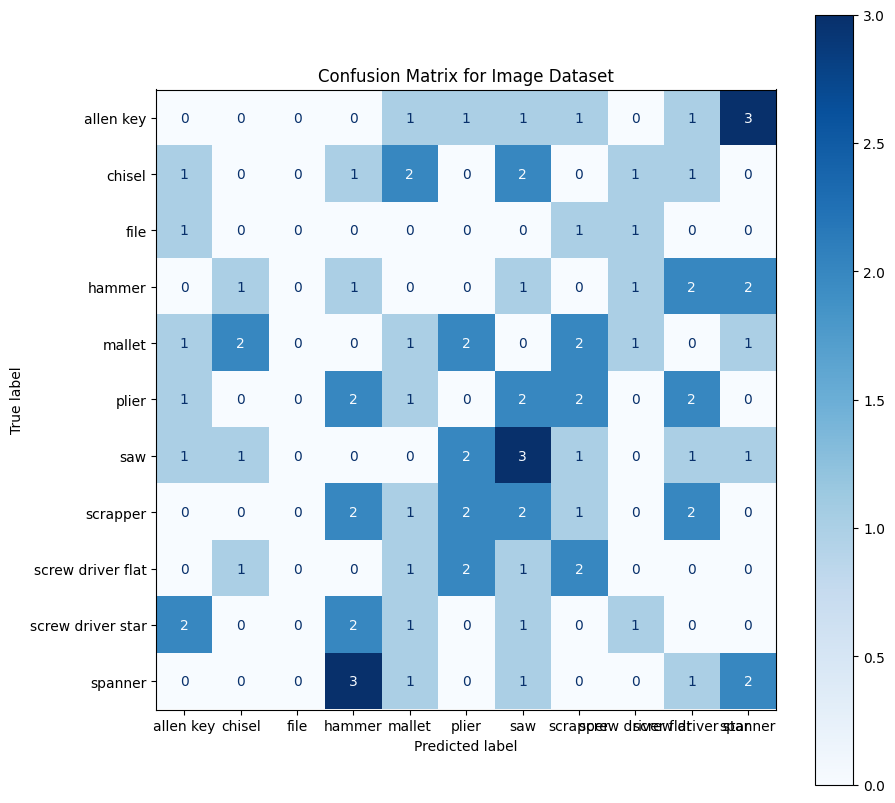

In [23]:
mobile_netv2_pred = make_predictions(mobile_netv2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step - accuracy: 0.7079 - loss: 0.9610
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
[[1 0 0 1 2 0 0 2 0 1 1]
 [0 0 0 0 3 0 2 0 2 1 0]
 [0 0 0 0 0 0 1 0 0 1 1]
 [1 0 1 2 2 0 1 0 0 1 0]
 [0 0 0 2 1 2 1 1 1 1 1]
 [1 0 0 2 0 3 1 1 0 1 1]
 [2 2 0 1 0 1 1 1 0 1 1]
 [2 2 0 1 0 2 0 1 0 1 1]
 [0 0 0 1 0 1 1 2 0 0 2]
 [1 1 1 0 0 1 1 2 0 0 0]
 [0 1 0 1 3 1 1 1 0 0 0]]


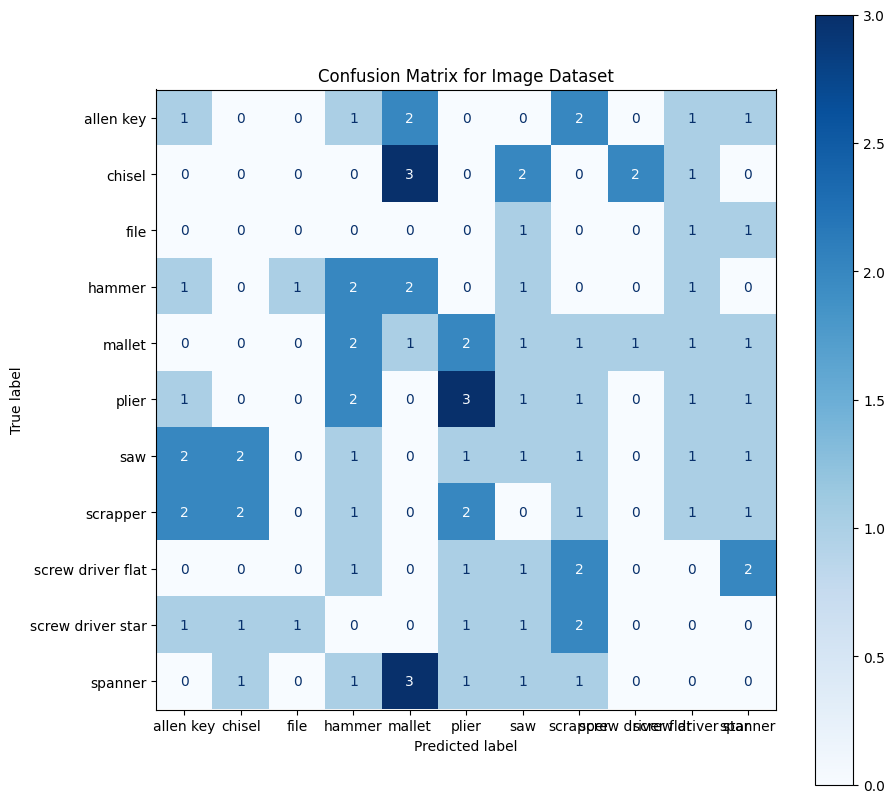

In [24]:
inception_netv2_pred = make_predictions(inception_v3)

In [25]:
history_mobile_netv2_finetune = mobile_netv2_finetune.fit(
    train_ds, 
    epochs=initial_epochs, 
    validation_data=val_ds, 
    callbacks=tensorboard_callback
)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.1012 - loss: 2.8189 - val_accuracy: 0.1744 - val_loss: 2.4850
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.3152 - loss: 2.0882 - val_accuracy: 0.3256 - val_loss: 2.0042
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4630 - loss: 1.6226 - val_accuracy: 0.4070 - val_loss: 1.7647
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.6109 - loss: 1.3590 - val_accuracy: 0.4884 - val_loss: 1.5713
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6926 - loss: 1.0892 - val_accuracy: 0.5465 - val_loss: 1.4151
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7198 - loss: 0.9289 - val_accuracy: 0.5698 - val_loss: 1.3072
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8288 - loss: 0.7687 - val_accuracy: 0.6047 - val_loss: 1.1918
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8288 - loss: 0.6588 - val_accuracy: 0.5581 - val_loss: 1.1766
Epoch 9/

In [26]:
history_inception_v3_finetune = inception_v3_finetune.fit(
    train_ds, 
    epochs=initial_epochs, 
    validation_data=val_ds, 
    callbacks=tensorboard_callback
)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.1595 - loss: 2.4292 - val_accuracy: 0.2907 - val_loss: 2.7315
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4630 - loss: 1.8069 - val_accuracy: 0.3605 - val_loss: 2.4082
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5837 - loss: 1.4527 - val_accuracy: 0.5349 - val_loss: 1.7732
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6732 - loss: 1.1689 - val_accuracy: 0.5930 - val_loss: 1.4870
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7704 - loss: 0.9453 - val_accuracy: 0.6163 - val_loss: 1.2509
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.7977 - loss: 0.7932 - val_accuracy: 0.6512 - val_loss: 1.1623
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8482 - loss: 0.6525 - val_accuracy: 0.6279 - val_loss: 1.0837
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.8521 - loss: 0.6305 - val_accuracy: 0.6744 - val_loss: 0.9789
Epoch 9

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8764 - loss: 0.4217
2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step  WARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1ab55d260> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step
[[1 0 0 1 1 0 1 0 1 1 2]
 [2 0 0 1 1 1 0 2 1 0 0]
 [0 0 0 0 1 0 1 0 0 1 0]
 [0 1 0 1 2 1 1 0 0 1 1]
 [2 1 1 0 0 1 1 2 0 1 1]
 [0 3 0 1 1 

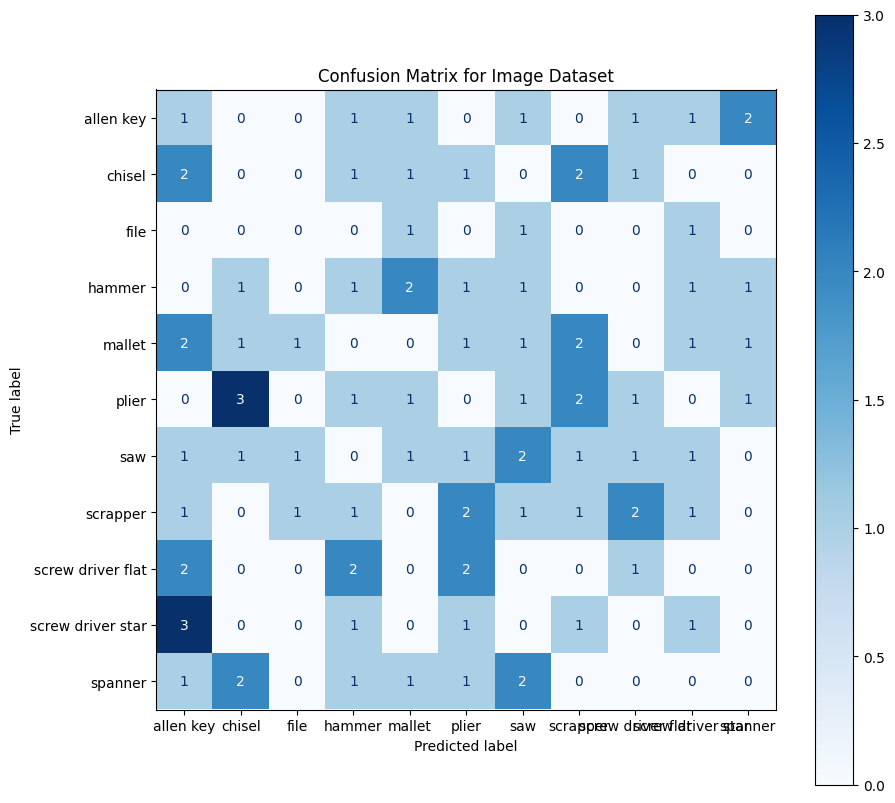

In [27]:
mobile_netv2_pred = make_predictions(mobile_netv2_finetune)

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8764 - loss: 0.3604
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step
[[1 1 1 0 1 0 1 1 1 0 1]
 [0 2 0 0 0 0 2 1 1 1 1]
 [0 0 0 1 0 1 1 0 0 0 0]
 [0 2 0 0 1 0 0 1 1 1 2]
 [0 0 0 1 2 0 3 1 0 1 2]
 [1 1 1 1 1 3 0 2 0 0 0]
 [1 1 0 0 0 1 0 0 2 3 2]
 [2 0 1 1 0 2 1 2 0 1 0]
 [1 1 1 0 1 0 1 2 0 0 0]
 [2 0 1 0 0 2 0 0 1 0 1]
 [0 0 0 1 2 1 1 0 1 1 1]]


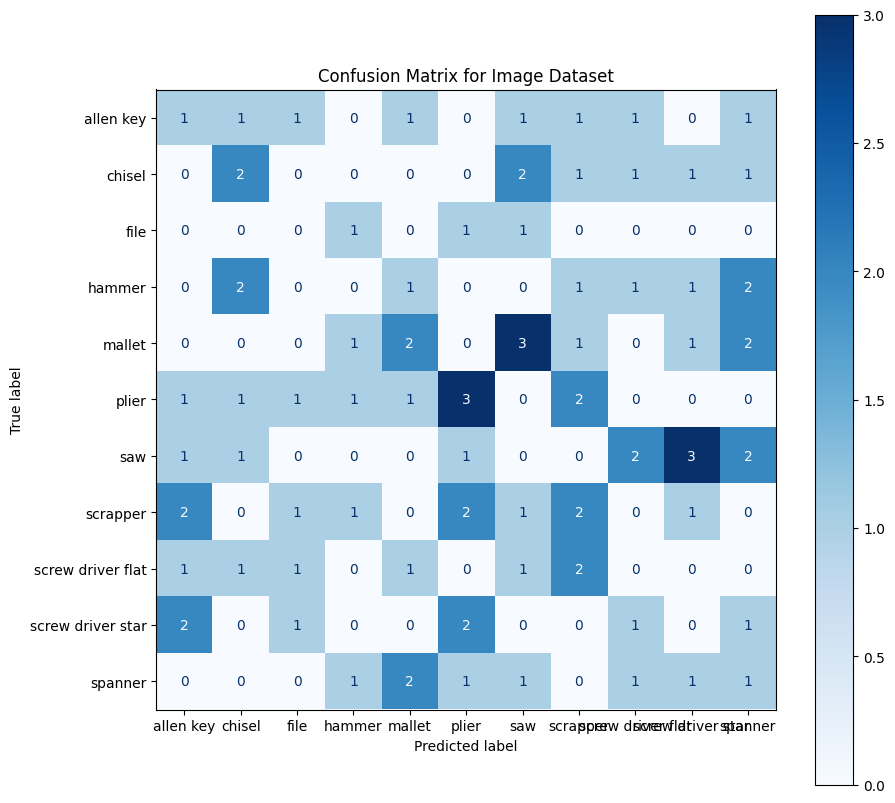

In [28]:
inception_netv2_pred = make_predictions(inception_v3_finetune)